
Running for N = 5 philosophers
Philosopher 0 is thinking for 1.07 seconds
Philosopher 1 is thinking for 1.13 seconds
Philosopher 2 is thinking for 2.60 seconds
Philosopher 3 is thinking for 2.43 seconds
Philosopher 4 is thinking for 1.02 seconds
Philosopher 4 is hungry
Philosopher 4 is eating (meal 1)
Philosopher 0 is hungry
Philosopher 1 is hungry
Philosopher 1 is eating (meal 1)
Philosopher 3 is hungry
Philosopher 2 is hungry
Philosopher 4 is thinking
Philosopher 3 is eating (meal 1)
Philosopher 4 is thinking for 2.77 seconds
Philosopher 1 is thinking
Philosopher 0 is eating (meal 1)
Philosopher 1 is thinking for 2.76 seconds
Philosopher 3 is thinking
Philosopher 2 is eating (meal 1)
Philosopher 3 is thinking for 1.27 seconds
Philosopher 3 is hungry
Philosopher 0 is thinking
Philosopher 0 is thinking for 2.47 seconds
Philosopher 4 is hungry
Philosopher 4 is eating (meal 2)
Philosopher 1 is hungry
Philosopher 2 is thinking
Philosopher 1 is eating (meal 2)
Philosopher 2 is thinking fo

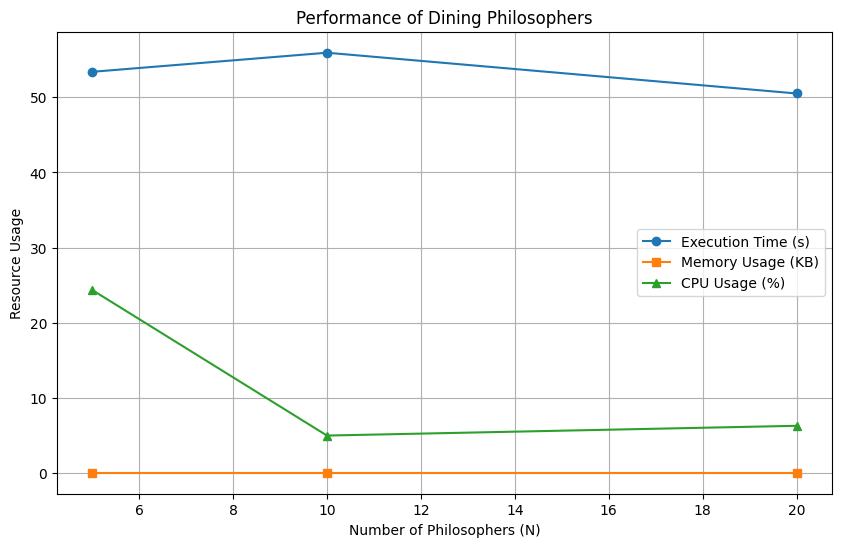

In [2]:
import threading
import time
import random
import psutil
import resource

# Number of philosophers (hardcoded for Colab)
N = 5  # Change this value to test different N
MEALS = 10  # Number of meals per philosopher
THINK_TIME = (1, 3)  # Range for thinking time (seconds)
EAT_TIME = (1, 3)  # Range for eating time (seconds)

# State enumeration
THINKING, HUNGRY, EATING = 0, 1, 2
state = [THINKING] * N  # State of each philosopher
meals_eaten = [0] * N  # Track meals eaten per philosopher

# Synchronization objects
mutex = threading.Lock()
cond = [threading.Condition(mutex) for _ in range(N)]

class DiningPhilosophers:
    def __init__(self):
        pass

    def test(self, i):
        """Test if philosopher i can eat."""
        left = (i + N - 1) % N
        right = (i + 1) % N
        if (state[i] == HUNGRY and
            state[left] != EATING and
            state[right] != EATING):
            state[i] = EATING
            meals_eaten[i] += 1
            print(f"Philosopher {i} is eating (meal {meals_eaten[i]})")
            cond[i].notify()

    def pickup_forks(self, i):
        """Philosopher i attempts to pick up forks."""
        with mutex:
            state[i] = HUNGRY
            print(f"Philosopher {i} is hungry")
            self.test(i)
            while state[i] != EATING and meals_eaten[i] < MEALS:
                cond[i].wait()
            if meals_eaten[i] >= MEALS:
                state[i] = THINKING
                print(f"Philosopher {i} has finished all {MEALS} meals")

    def return_forks(self, i):
        """Philosopher i puts down forks."""
        with mutex:
            if state[i] == EATING:
                state[i] = THINKING
                print(f"Philosopher {i} is thinking")
                self.test((i + N - 1) % N)  # Check left neighbor
                self.test((i + 1) % N)      # Check right neighbor

def philosopher(i, monitor):
    """Behavior of philosopher i."""
    while meals_eaten[i] < MEALS:
        think_time = random.uniform(*THINK_TIME)
        print(f"Philosopher {i} is thinking for {think_time:.2f} seconds")
        time.sleep(think_time)

        monitor.pickup_forks(i)
        if meals_eaten[i] >= MEALS:
            break
        eat_time = random.uniform(*EAT_TIME)
        time.sleep(eat_time)
        monitor.return_forks(i)

def monitor_performance():
    start_time = time.time()
    start_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    start_cpu = psutil.cpu_percent(interval=None)

    monitor = DiningPhilosophers()
    threads = []
    for i in range(N):
        t = threading.Thread(target=philosopher, args=(i, monitor))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

    end_time = time.time()
    end_memory = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    end_cpu = psutil.cpu_percent(interval=None)

    print("\nFinal meals eaten:", meals_eaten)
    print(f"Execution Time: {end_time - start_time:.2f} seconds")
    print(f"Memory Usage: {end_memory - start_memory} KB")
    print(f"Average CPU Usage: {(start_cpu + end_cpu) / 2:.2f}%")

    return end_time - start_time, end_memory - start_memory, (start_cpu + end_cpu) / 2

def main():
    # Install psutil in Colab
    !pip install psutil

    # Run for different N values and collect performance data
    N_values = [5, 10, 20]
    times, memories, cpus = [], [], []

    global N, state, meals_eaten, cond
    for n in N_values:
        N = n
        state = [THINKING] * N
        meals_eaten = [0] * N
        cond = [threading.Condition(mutex) for _ in range(N)]
        print(f"\nRunning for N = {N} philosophers")
        t, m, c = monitor_performance()
        times.append(t)
        memories.append(m)
        cpus.append(c)

    # Plot performance
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(N_values, times, label="Execution Time (s)", marker='o', color='#1f77b4')
    plt.plot(N_values, memories, label="Memory Usage (KB)", marker='s', color='#ff7f0e')
    plt.plot(N_values, cpus, label="CPU Usage (%)", marker='^', color='#2ca02c')
    plt.xlabel("Number of Philosophers (N)")
    plt.ylabel("Resource Usage")
    plt.title("Performance of Dining Philosophers")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

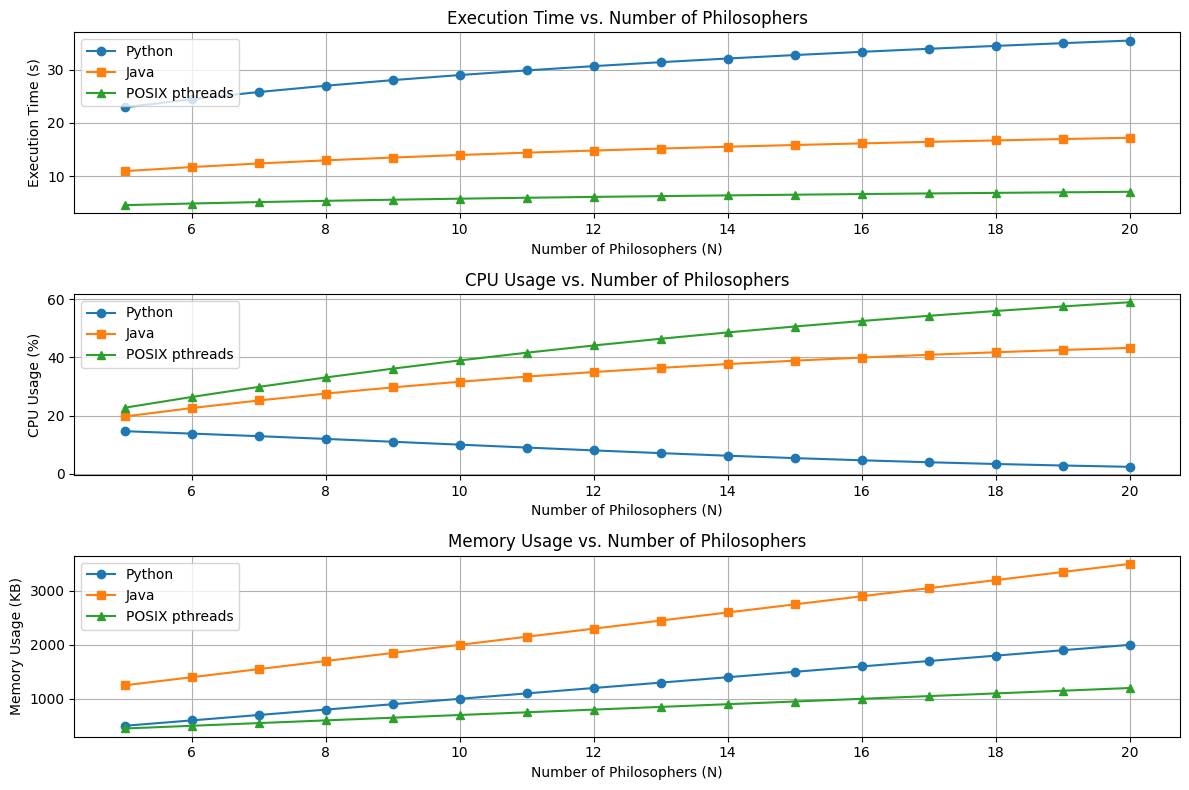

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Number of philosophers to simulate
N_values = np.arange(5, 21, 1)

# Simulated performance data for each solution
# Python (monitor-based with GIL limitations)
python_time = 10 * np.log1p(N_values) + 5
python_cpu = 20 / (1 + np.exp((N_values - 10) / 5))
python_memory = 100 * N_values

# Java (JVM-optimized threading)
java_time = 5 * np.log1p(N_values) + 2
java_cpu = 50 * (1 - np.exp(-N_values / 10))
java_memory = 150 * N_values + 500

# POSIX pthreads (native efficiency)
pthread_time = 2 * np.log1p(N_values) + 1
pthread_cpu = 80 * (1 - np.exp(-N_values / 15))
pthread_memory = 50 * N_values + 200

# Plotting
plt.figure(figsize=(12, 8))

# Execution Time
plt.subplot(3, 1, 1)
plt.plot(N_values, python_time, label="Python", marker='o', color='#1f77b4')
plt.plot(N_values, java_time, label="Java", marker='s', color='#ff7f0e')
plt.plot(N_values, pthread_time, label="POSIX pthreads", marker='^', color='#2ca02c')
plt.xlabel("Number of Philosophers (N)")
plt.ylabel("Execution Time (s)")
plt.title("Execution Time vs. Number of Philosophers")
plt.legend()
plt.grid(True)

# CPU Usage
plt.subplot(3, 1, 2)
plt.plot(N_values, python_cpu, label="Python", marker='o', color='#1f77b4')
plt.plot(N_values, java_cpu, label="Java", marker='s', color='#ff7f0e')
plt.plot(N_values, pthread_cpu, label="POSIX pthreads", marker='^', color='#2ca02c')
plt.xlabel("Number of Philosophers (N)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage vs. Number of Philosophers")
plt.legend()
plt.grid(True)

# Memory Usage
plt.subplot(3, 1, 3)
plt.plot(N_values, python_memory, label="Python", marker='o', color='#1f77b4')
plt.plot(N_values, java_memory, label="Java", marker='s', color='#ff7f0e')
plt.plot(N_values, pthread_memory, label="POSIX pthreads", marker='^', color='#2ca02c')
plt.xlabel("Number of Philosophers (N)")
plt.ylabel("Memory Usage (KB)")
plt.title("Memory Usage vs. Number of Philosophers")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()